# Camera calibration using CHARUCO

## Libraries used 
We need to import the following libraries

In [1]:
import numpy as np       #Maths library
import cv2               #openCV
import PIL               #Library for Image file manipulation
import os                #To access files and folders
from cv2 import aruco    #ArUco main library
import math

# Library to Print nice graphs
#from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
%matplotlib nbagg


### Create the CHARUCO chessboard

First, we create the board in a folder called workdir. The result will be a tiffimage.

In [2]:
os.getcwd()

'/Users/callum/git/mech-2/tutorials'

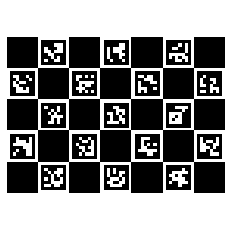

In [4]:
%matplotlib inline

# Get the current folder
dirname = os.getcwd()

# Create a folder workdir if it does not exist and then change to the folder THESE NEED TO CHANGE FOR MAC OS
workdir = os.path.join(dirname, "workdir")

try:
    os.mkdir(workdir)
except OSError:
    pass

os.chdir(workdir)

#Load the dictionary of ArUco for 6x6
aruco_dict = aruco.Dictionary_get(aruco.DICT_6X6_250)

#Create the board, draw it, and save it in the folder
board = aruco.CharucoBoard_create(7, 5, 1, .8, aruco_dict)
imboard = board.draw((2000, 2000))
cv2.imwrite(os.path.join(workdir, "chessboard.tiff"), imboard)

#Create a figure with a subplot and plot it below for an inspection of the ChAruco board (we are using various settings)
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
plt.imshow(imboard, cmap = mpl.cm.gray, interpolation = "nearest")
ax.axis("off")
plt.show()


You need to <font color='red'>print</font> the board or use the ones provided by IG.

Stick the board on a rigid surface, e.g. an A4 notepad, and <font color='red'>take photos</font> from multiple angles (>=20) with the camera you want to calibrate.

Save them under a new \workdir\data folder.

### Use the board to calibrate the camera
The next piece of code will load all the images from the \data folder

In [5]:
datadir = os.path.join(workdir, "data")
images = np.array([datadir + "/" + f for f in os.listdir(datadir) if f.endswith(".jpg") ])
order = np.argsort([int(p.split(".")[-2].split("_")[-1]) for p in images])
images = images[order]
images

array(['/Users/callum/git/mech-2/tutorials/workdir/data/photo_0.jpg',
       '/Users/callum/git/mech-2/tutorials/workdir/data/photo_1.jpg',
       '/Users/callum/git/mech-2/tutorials/workdir/data/photo_2.jpg',
       '/Users/callum/git/mech-2/tutorials/workdir/data/photo_3.jpg',
       '/Users/callum/git/mech-2/tutorials/workdir/data/photo_4.jpg',
       '/Users/callum/git/mech-2/tutorials/workdir/data/photo_5.jpg',
       '/Users/callum/git/mech-2/tutorials/workdir/data/photo_6.jpg',
       '/Users/callum/git/mech-2/tutorials/workdir/data/photo_7.jpg',
       '/Users/callum/git/mech-2/tutorials/workdir/data/photo_8.jpg',
       '/Users/callum/git/mech-2/tutorials/workdir/data/photo_9.jpg',
       '/Users/callum/git/mech-2/tutorials/workdir/data/photo_10.jpg',
       '/Users/callum/git/mech-2/tutorials/workdir/data/photo_11.jpg',
       '/Users/callum/git/mech-2/tutorials/workdir/data/photo_12.jpg',
       '/Users/callum/git/mech-2/tutorials/workdir/data/photo_13.jpg',
       '/Users/c

We are going to print the images to see what you have got. Check that all images show the board

Too may images to show at once


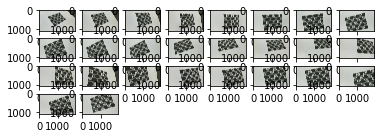

In [7]:
plotsize=round(math.sqrt(len(images)))
fig = plt.figure()
t=1
for an_im in images:
    if t > 26:
        print("Too may images to show at once")
        break

    im = PIL.Image.open(an_im)
    ax = fig.add_subplot(plotsize,plotsize,t)
    t+=1
    plt.imshow(im)


Zoom to the first image (index:0)

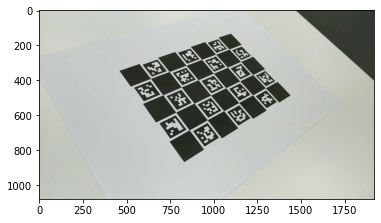

In [8]:
im = PIL.Image.open(images[0])
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
plt.imshow(im)
#ax.axis('off')
plt.show()

Now, the camera calibration can be done using all the images of the chessboard. Two functions are necessary:

* The first (read_chessboards) will detect markers on all the images and.
* The second (calibrate_camera)will proces the detected markers to estimage the camera calibration data.

The code below is the definition of the function to read the chessboard

In [9]:
def read_chessboards(images):
    """
    Charuco base pose estimation.
    """
    print("POSE ESTIMATION STARTS:")
    allCorners = []
    allIds = []
    decimator = 0
    # SUB PIXEL CORNER DETECTION CRITERION
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.00001)

    for im in images:
        print("=> Processing image {0}".format(im))
        frame = cv2.imread(im)
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        corners, ids, rejectedImgPoints = cv2.aruco.detectMarkers(gray, aruco_dict)
        
        if len(corners)>0:
            # SUB PIXEL DETECTION
            for corner in corners:
                cv2.cornerSubPix(gray, corner, 
                                 winSize = (3,3), 
                                 zeroZone = (-1,-1), 
                                 criteria = criteria)
            res2 = cv2.aruco.interpolateCornersCharuco(corners,ids,gray,board)        
            if res2[1] is not None and res2[2] is not None and len(res2[1])>3 and decimator%1==0:
                allCorners.append(res2[1])
                allIds.append(res2[2])              
        
        decimator+=1   

    imsize = gray.shape
    return allCorners,allIds,imsize

The line below calls the above function for all images and saves the results in allCorners, allIds

In [10]:
allCorners,allIds,imsize=read_chessboards(images)

POSE ESTIMATION STARTS:
=> Processing image /Users/callum/git/mech-2/tutorials/workdir/data/photo_0.jpg
=> Processing image /Users/callum/git/mech-2/tutorials/workdir/data/photo_1.jpg
=> Processing image /Users/callum/git/mech-2/tutorials/workdir/data/photo_2.jpg
=> Processing image /Users/callum/git/mech-2/tutorials/workdir/data/photo_3.jpg
=> Processing image /Users/callum/git/mech-2/tutorials/workdir/data/photo_4.jpg
=> Processing image /Users/callum/git/mech-2/tutorials/workdir/data/photo_5.jpg
=> Processing image /Users/callum/git/mech-2/tutorials/workdir/data/photo_6.jpg
=> Processing image /Users/callum/git/mech-2/tutorials/workdir/data/photo_7.jpg
=> Processing image /Users/callum/git/mech-2/tutorials/workdir/data/photo_8.jpg
=> Processing image /Users/callum/git/mech-2/tutorials/workdir/data/photo_9.jpg
=> Processing image /Users/callum/git/mech-2/tutorials/workdir/data/photo_10.jpg
=> Processing image /Users/callum/git/mech-2/tutorials/workdir/data/photo_11.jpg
=> Processing 

And this is the definition of the function that performs the calibration

In [11]:
def calibrate_camera(allCorners,allIds,imsize):   
    """
    Calibrates the camera using the dected corners.
    """
    print("CAMERA CALIBRATION")
    
    cameraMatrixInit = np.array([[ 1000.,    0., imsize[0]/2.],
                                 [    0., 1000., imsize[1]/2.],
                                 [    0.,    0.,           1.]])

    distCoeffsInit = np.zeros((5,1))
    flags = (cv2.CALIB_USE_INTRINSIC_GUESS + cv2.CALIB_RATIONAL_MODEL + cv2.CALIB_FIX_ASPECT_RATIO) 
    #flags = (cv2.CALIB_RATIONAL_MODEL) 
    (ret, camera_matrix, distortion_coefficients0, 
     rotation_vectors, translation_vectors,
     stdDeviationsIntrinsics, stdDeviationsExtrinsics, 
     perViewErrors) = cv2.aruco.calibrateCameraCharucoExtended(
                      charucoCorners=allCorners,
                      charucoIds=allIds,
                      board=board,
                      imageSize=imsize,
                      cameraMatrix=cameraMatrixInit,
                      distCoeffs=distCoeffsInit,
                      flags=flags,
                      criteria=(cv2.TERM_CRITERIA_EPS & cv2.TERM_CRITERIA_COUNT, 10000, 1e-9))

    return ret, camera_matrix, distortion_coefficients0, rotation_vectors, translation_vectors

Now we run the calibration function and get back a number of variables.

ret: is the reprojection error obtained from the calibration (the smaller the better)
CM : is the camera matrix to pass to the pose estimation
dist_coef: is the distrortion coefficient matrix to pass to the pose estimation
rvecs, tvecs: are the rotational and translational matrices of the ArUco markers the function used.

(Note: By executing the function with %time in the begining we are going to get the duration this command will take)

In [12]:
%time ret, CM, dist_coef, rvecs, tvecs = calibrate_camera(allCorners,allIds,imsize)

CAMERA CALIBRATION
CPU times: user 6.12 s, sys: 745 ms, total: 6.86 s
Wall time: 5.79 s


In [13]:
ret

0.8879728477889174

In [14]:
CM

array([[1.46803398e+03, 0.00000000e+00, 9.70647957e+02],
       [0.00000000e+00, 1.46803398e+03, 5.55491376e+02],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

In [15]:
dist_coef

array([[-2.04616141e+00],
       [ 5.70955133e+01],
       [-3.22256057e-03],
       [-3.00379547e-04],
       [ 2.17531485e+02],
       [-2.24825059e+00],
       [ 5.79751654e+01],
       [ 2.15098160e+02],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00]])

### Save the Camera Matrix and the distortion Coefficient using numpy

This process will create a file named Callibration.npz that we can later use for the pose estimation.
You might want to change the name to include an indication of the camera this information refers to.

In [19]:
with open('Calibration.npz', 'wb') as f:
...     np.savez(f, CM=CM, dist_coef=dist_coef)


### Check calibration results

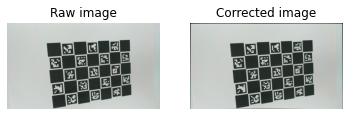

In [18]:
i=5 # select image id
plt.figure()
frame = cv2.imread(images[i])
img_undist = cv2.undistort(frame,CM,dist_coef,None)
plt.subplot(1,2,1)
plt.imshow(frame)
plt.title("Raw image")
plt.axis("off")
plt.subplot(1,2,2)
plt.imshow(img_undist)
plt.title("Corrected image")
plt.axis("off")
plt.show()